In [1]:
import pandas as pd
import numpy as np
import scipy.stats
from sklearn import metrics

trialOrders = {}

import os

path = './events'

def compute_skourascore(subject_performace, idealized_performance):
    return scipy.stats.pearsonr(subject_performace, idealized_performance)[0]

def compute_auc_score(counterbalanced_angles, length):
    score = metrics.auc(np.arange(length * 1.0), counterbalanced_angles) / metrics.auc(np.arange(length * 1.0), np.full((length, 1), 90))
    return score

def compute_peak_score(counterbalanced_angles):
    return np.amax(counterbalanced_angles)

def compute_ttp_score(counterbalanced_angles):
    return np.argmax(counterbalanced_angles)

def find_empty_times(data):
    intermissions = data[data['instruction']==" Push Button"].index.tolist()
    rests = data[data['instruction']==" Rest"]
    first_scan_index = data[data['instruction']!=" Rest"].index.tolist()[0] - 1
    first_rest_at_end = data[data['instruction']!=" Rest"].index.tolist()[-1] + 1
    times = [first_scan_index] + intermissions + [first_rest_at_end]
    return times

def determine_trialorder(data, times):
    trialOrder = []
    for trialnum in range(12):
        this_trial = data[(times[trialnum] + 1):times[trialnum + 1]][data['feedback']=="On"]
        trialOrder += [this_trial['left_text'].tolist()[0][1:] + "-" + this_trial['right_text'].tolist()[0][1:], this_trial['instruction'].tolist()[0][1:]]
    return trialOrder

files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if '.tsv' in file:
            files.append(os.path.join(r, file))
            

In [2]:
import copy
means_template = {'ID':[], 'down': [], 'up': [], 'both': []}

series_template = {'ID':[]}
for i in range(1, 13):
    series_template[str(i)] = []

downseries_template = {'ID':[]}
for i in range(1, 7):
    downseries_template[str(i)] = []
    
upseries_template = {'ID':[]}
for i in range(1, 7):
    upseries_template[str(i)] = []

skouradict = {'means':copy.deepcopy(means_template), 'series':copy.deepcopy(series_template), 'downseries':copy.deepcopy(downseries_template), 'upseries': copy.deepcopy(upseries_template)}
aucdict = {'means':copy.deepcopy(means_template), 'series':copy.deepcopy(series_template), 'downseries':copy.deepcopy(downseries_template), 'upseries': copy.deepcopy(upseries_template)}
peakdict = {'means':copy.deepcopy(means_template), 'series':copy.deepcopy(series_template), 'downseries':copy.deepcopy(downseries_template), 'upseries': copy.deepcopy(upseries_template)}
ttpdict = {'means':copy.deepcopy(means_template), 'series':copy.deepcopy(series_template), 'downseries':copy.deepcopy(downseries_template), 'upseries': copy.deepcopy(upseries_template)}

for i in range(len(files)):
    #parsing filename to find NKI subject ID
    subpos = files[i].find('sub-A')
    subjID = files[i][(subpos + 4):(subpos + 13)]
    #reading events.tsv file as "data"
    data = pd.read_csv(files[i], sep="\t")
    times = find_empty_times(data)
    trialOrder = determine_trialorder(data, times)
    
    skouradict['series']['ID'] += [subjID]
    skouradict['upseries']['ID'] += [subjID]
    skouradict['downseries']['ID'] += [subjID]
    
    aucdict['series']['ID'] += [subjID]
    aucdict['upseries']['ID'] += [subjID]
    aucdict['downseries']['ID'] += [subjID]
    
    peakdict['series']['ID'] += [subjID]
    peakdict['upseries']['ID'] += [subjID]
    peakdict['downseries']['ID'] += [subjID]
    
    ttpdict['series']['ID'] += [subjID]
    ttpdict['upseries']['ID'] += [subjID]
    ttpdict['downseries']['ID'] += [subjID]
    
    series_position = 1
    downseries_position = 1
    upseries_position = 1
    
    for trialnum in range(12):
        #this_trial is the data just from the trial of trialnum
        #this_trial is set to the FIRST 15 TRs (first 30 seconds) of each trial!
        this_trial = data[(times[trialnum] + 1):times[trialnum + 1]][0:16]
        length = len(this_trial.needle_position.values)
        instruction = trialOrder[(trialnum * 2) + 1]
        polarity = trialOrder[(trialnum * 2)]
        if instruction == "Focus":
            if polarity == 'Focused-Wandering':
                idealized = np.linspace(90, 90 + (length - 1), num=length)
                auc_balanced = (this_trial.needle_position.values - 90)
            elif polarity == 'Wandering-Focused':
                idealized = np.linspace(90, 90 - (length - 1), num=length)
                auc_balanced = (this_trial.needle_position.values - 90) * -1
            
            #calculating scores
            auc = compute_auc_score(auc_balanced, length)
            skourascore = compute_skourascore(this_trial.needle_position.values, idealized)
            peak = compute_peak_score(auc_balanced)
            ttp = compute_ttp_score(auc_balanced)
            
            #storing scores in memory
            skouradict['downseries'][str(downseries_position)] += [skourascore]
            aucdict['downseries'][str(downseries_position)] += [auc]
            peakdict['downseries'][str(downseries_position)] += [peak]
            ttpdict['downseries'][str(downseries_position)] += [ttp]
            
            downseries_position += 1
        elif instruction == "Wander":
            if polarity == 'Focused-Wandering':
                idealized = np.linspace(90, 90 - (length - 1), num=length)
                auc_balanced = (this_trial.needle_position.values - 90) * -1
            elif polarity == 'Wandering-Focused':
                idealized = np.linspace(90, 90 + (length - 1), num=length)
                auc_balanced = (this_trial.needle_position.values - 90)
            
            #calculating scores
            auc = compute_auc_score(auc_balanced, length)
            skourascore = compute_skourascore(this_trial.needle_position.values, idealized)
            peak = compute_peak_score(auc_balanced)
            ttp = compute_ttp_score(auc_balanced)
            
            #storing scores in memory
            skouradict['upseries'][str(upseries_position)] += [skourascore]
            aucdict['upseries'][str(upseries_position)] += [auc]
            peakdict['upseries'][str(upseries_position)] += [peak]
            ttpdict['upseries'][str(upseries_position)] += [ttp]
            
            upseries_position += 1
        else:
            print("something is horribly wrong")
        skouradict['series'][str(series_position)] += [skourascore]
        aucdict['series'][str(series_position)] += [auc]
        peakdict['series'][str(series_position)] += [peak]
        ttpdict['series'][str(series_position)] += [ttp]
        
        series_position += 1

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [3]:
#convert series dicts into dataframes
#first skourascores
skouraseries = pd.DataFrame(skouradict['series'])
skouradownseries = pd.DataFrame(skouradict['downseries'])
skouraupseries = pd.DataFrame(skouradict['upseries'])
#now AUC scores
aucseries = pd.DataFrame(aucdict['series'])
aucdownseries = pd.DataFrame(aucdict['downseries'])
aucupseries = pd.DataFrame(aucdict['upseries'])
#now peak scores
ttpseries = pd.DataFrame(ttpdict['series'])
ttpdownseries = pd.DataFrame(ttpdict['downseries'])
ttpupseries = pd.DataFrame(ttpdict['upseries'])
#now TTP scores
peakseries = pd.DataFrame(peakdict['series'])
peakdownseries = pd.DataFrame(peakdict['downseries'])
peakupseries = pd.DataFrame(peakdict['upseries'])

#now sort them by IDs
skouraseries.sort_values(by=['ID'])
skouradownseries.sort_values(by=['ID'])
skouraupseries.sort_values(by=['ID'])
aucseries.sort_values(by=['ID'])
aucdownseries.sort_values(by=['ID'])
aucupseries.sort_values(by=['ID'])
ttpseries.sort_values(by=['ID'])
ttpdownseries.sort_values(by=['ID'])
ttpupseries.sort_values(by=['ID'])
peakseries.sort_values(by=['ID'])
peakdownseries.sort_values(by=['ID'])
peakupseries.sort_values(by=['ID'])
None;

Function for calculating skouras-style "learning" score. "learning" in this context is measured as the average of trials 4-6 minus the average of trials 1-3. This "learning" measurement is independent of score-type, and can be calculated for each one.

It also calculates the 6-1 learning measure.

I define a function for calculating "learning" here.

In [4]:
#this function assumes a trial-series of length 6 (either up or down regulation, but not both)
def add_learning_measures(series):
    series['first_avg'] = series[['1', '2','3']].mean(axis=1)
    series['second_avg'] = series[['4', '5','6']].mean(axis=1)
    series['skouras_learning'] = series['second_avg'] - series['first_avg']
    series['six_minus_one'] = series['6'] - series['1']
    series['difference_between_measures'] = series['six_minus_one'] - series['skouras_learning']
    return series

In [5]:
%matplotlib notebook

Create function for plotting learning curves and histograms of arbitrary # of trials

In [6]:
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats

def learningcurve(seriesdata, length, scoretype):
    x = []
    for i in range(length):
        x += [i + 1]

    series = pd.DataFrame(seriesdata)
    series = series.sort_values(by=['ID'])
    series = series.to_numpy()
    fig, ax = plt.subplots(2, 1)
    diffs = []
    for j in range(len(series)):
        x=np.asarray(x).astype(np.float)
        ax[0].scatter(x, series[j][1:], color='b', alpha=0.1)
        diffs += [series[j][6] - series[j][1]]
        y = series[j][1:].astype(np.float)
        slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"r", alpha=0.2)
    ax[1].hist(diffs, 4)
    # set ticks and tick labels
    ax[0].set_xlim((1, length))
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(x)

    plt.xlabel('Trial Position (not the actual trial number)')
    plt.ylabel('Score')
    plt.title(scoretype + ' learning curves')
    plt.tight_layout()

    plt.show()
    
def series_histogram(seriesdata, scoretype, length, n_bins):
    series = pd.DataFrame(seriesdata)
    series = series.sort_values(by=['ID'])

    fig, axs = plt.subplots(length, 1, sharey=True, sharex=True)
    for trialPos in range(length):
        axs[trialPos].hist(series[str(trialPos + 1)].to_list(), bins=n_bins)
        axs[trialPos].set_title(scoretype + ' Trial ' + str(trialPos + 1))
    plt.xlabel('Score')
    plt.tight_layout()
    plt.show()

AUC score
Average difference between measures = 0.0630908714822483
skouras_learning measure has a variance of 0.02729042076589649
6-1 measure has a variance of 0.06024195825315807
Here is a random sample of 10 subjects.
     skouras_learning  six_minus_one  difference_between_measures
131         -0.150533       0.022816                     0.173349
6            0.017894       0.084634                     0.066739
2            0.419929       0.205335                    -0.214593
73           0.453215       0.610249                     0.157033
53          -0.058063       0.568142                     0.626205
55           0.045965       0.130778                     0.084813
29           0.303505       0.499922                     0.196417
8            0.024903       0.187607                     0.162703
46           0.278420       0.287625                     0.009205
118         -0.087600      -0.197538                    -0.109938


<IPython.core.display.Javascript object>


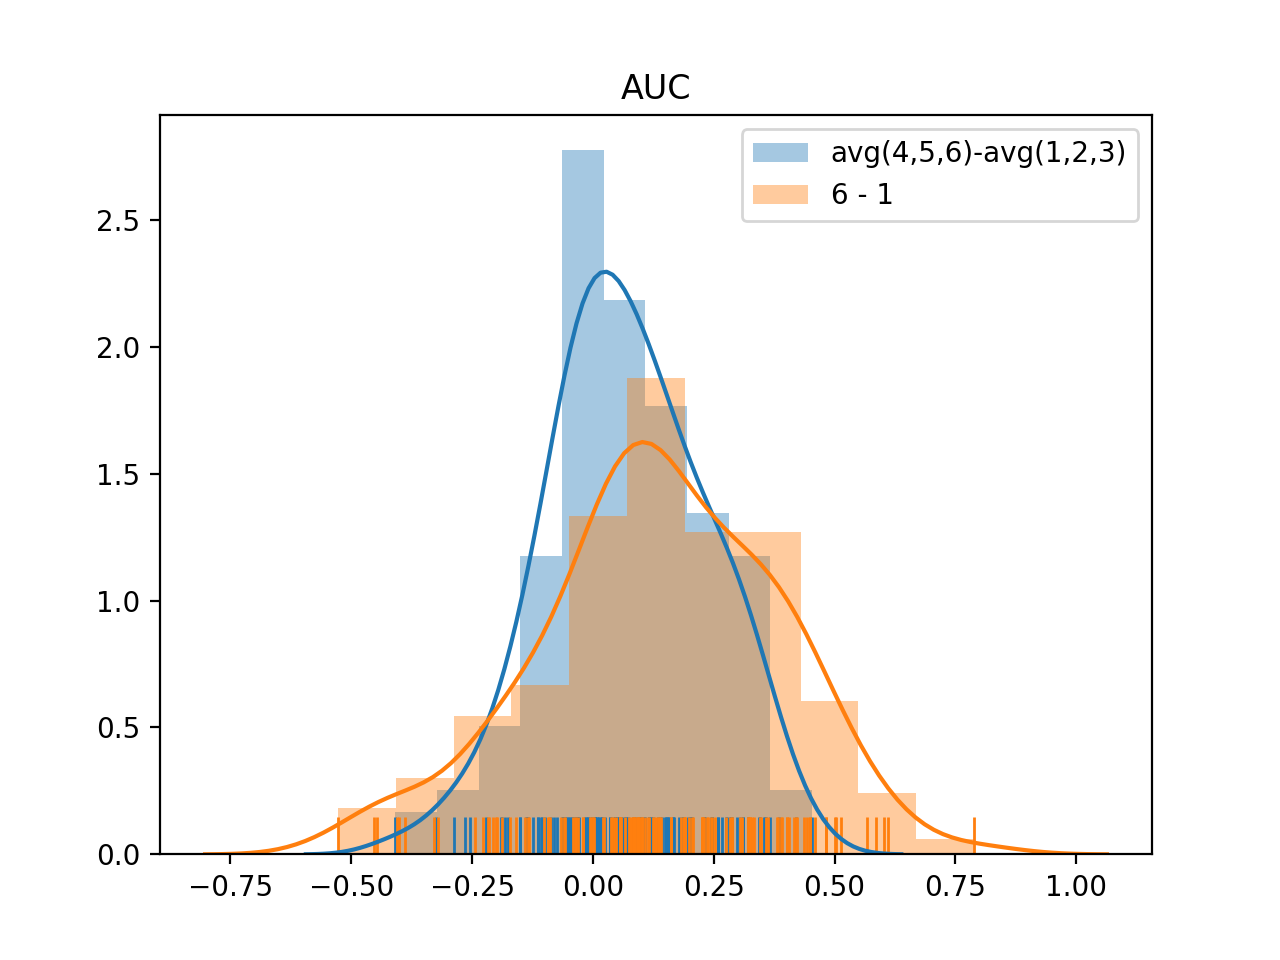

Skouras-Score score
Average difference between measures = 0.22386961859401464
skouras_learning measure has a variance of 0.34324545639808096
6-1 measure has a variance of 0.7942864036260321
Here is a random sample of 10 subjects.
     skouras_learning  six_minus_one  difference_between_measures
53           0.132053       1.938407                     1.806353
133          0.351070       0.085917                    -0.265153
107          0.137526       1.596408                     1.458882
52           0.345921       0.157990                    -0.187931
67           0.139478       0.101587                    -0.037891
30           0.234223      -1.766547                    -2.000770
55           0.085459       0.037629                    -0.047830
103          0.653619       1.442859                     0.789239
118         -0.570819      -0.037453                     0.533366
12           0.172599       1.466069                     1.293470


<IPython.core.display.Javascript object>


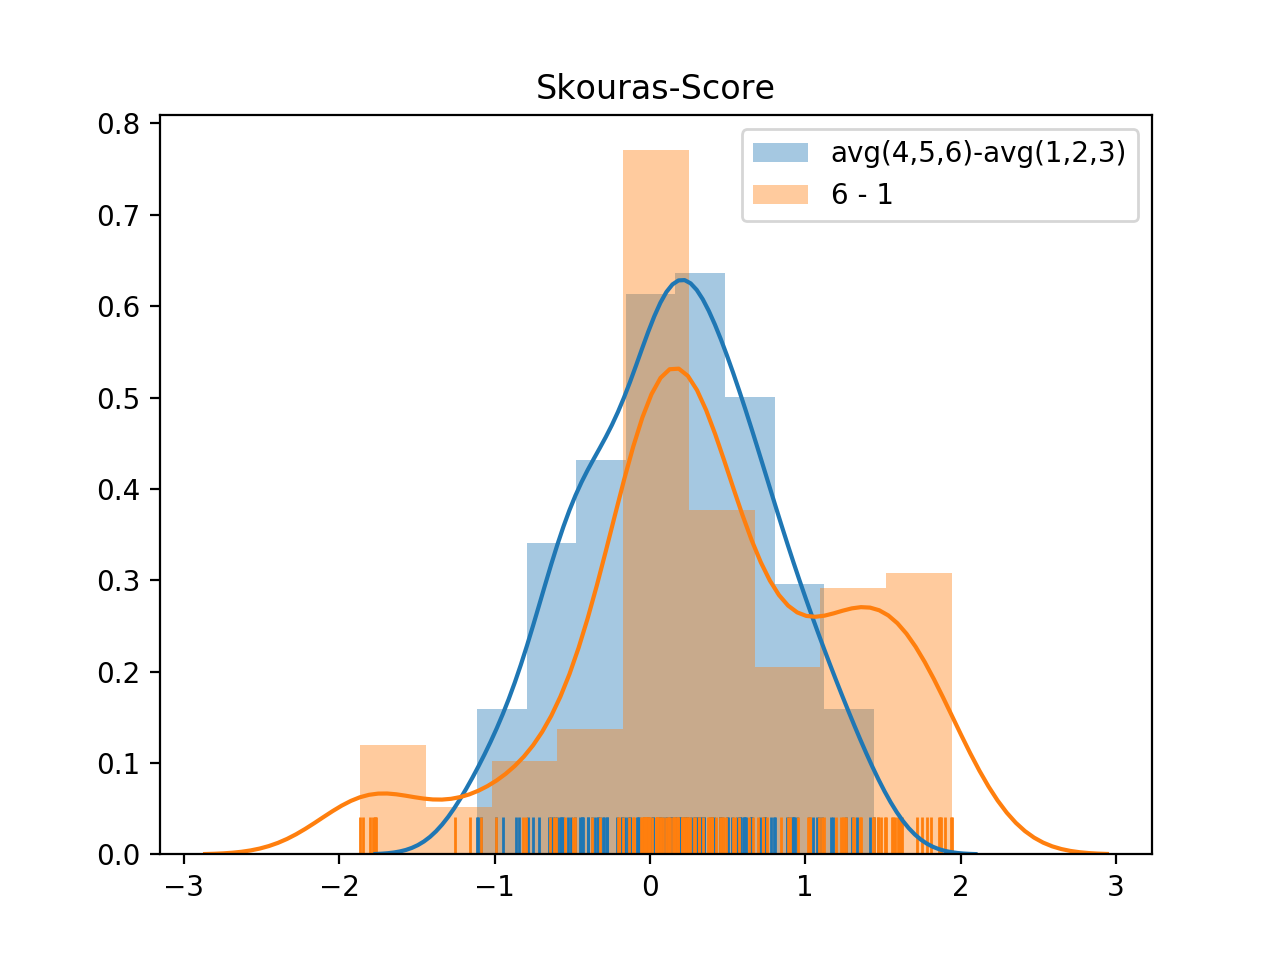

Time-to-peak score
Average difference between measures = 1.357487922705314
skouras_learning measure has a variance of 19.323770683096456
6-1 measure has a variance of 45.101711825246795
Here is a random sample of 10 subjects.
    skouras_learning  six_minus_one  difference_between_measures
68         -5.333333             -4                     1.333333
34         -0.333333             -3                    -2.666667
55          3.000000              1                    -2.000000
32         -1.000000              3                     4.000000
69         -6.333333             -4                     2.333333
7          -4.333333              6                    10.333333
78          9.000000             14                     5.000000
86         -6.333333              0                     6.333333
38          2.666667              1                    -1.666667
61          0.666667             -1                    -1.666667


<IPython.core.display.Javascript object>


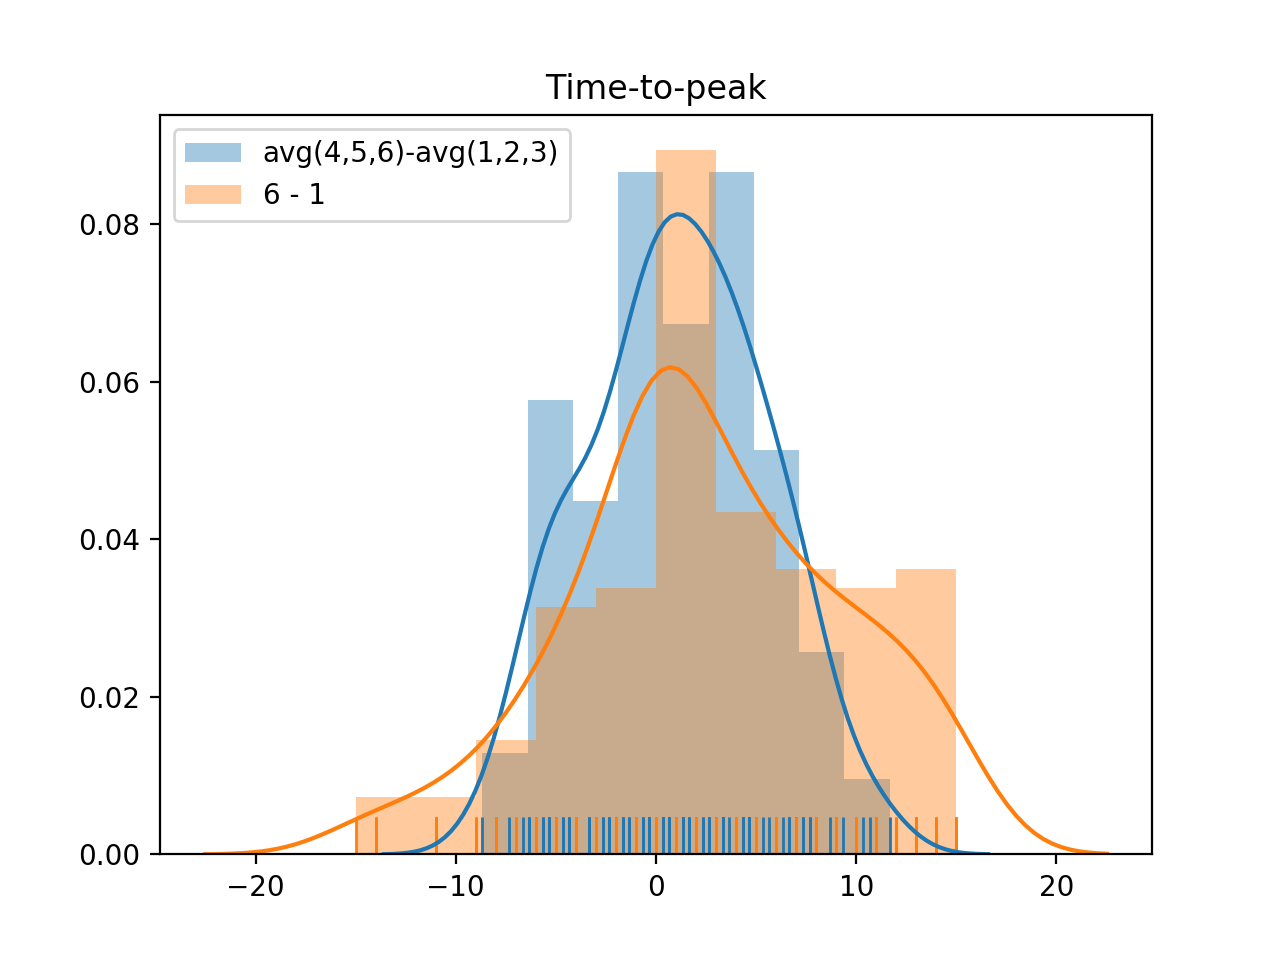

Peak score
Average difference between measures = 13.050876811594202
skouras_learning measure has a variance of 374.07655983279074
6-1 measure has a variance of 840.7700150674228
Here is a random sample of 10 subjects.
     skouras_learning  six_minus_one  difference_between_measures
82          54.461333         67.614                    13.152667
132          7.139667         11.112                     3.972333
125         34.487000         49.316                    14.829000
86          -7.938333         30.348                    38.286333
60         -18.281000        -73.825                   -55.544000
15          20.891000          4.055                   -16.836000
97           3.051333        -28.781                   -31.832333
48          -3.991333         15.075                    19.066333
35          39.744000         58.604                    18.860000
112         -2.881000        -22.468                   -19.587000


<IPython.core.display.Javascript object>


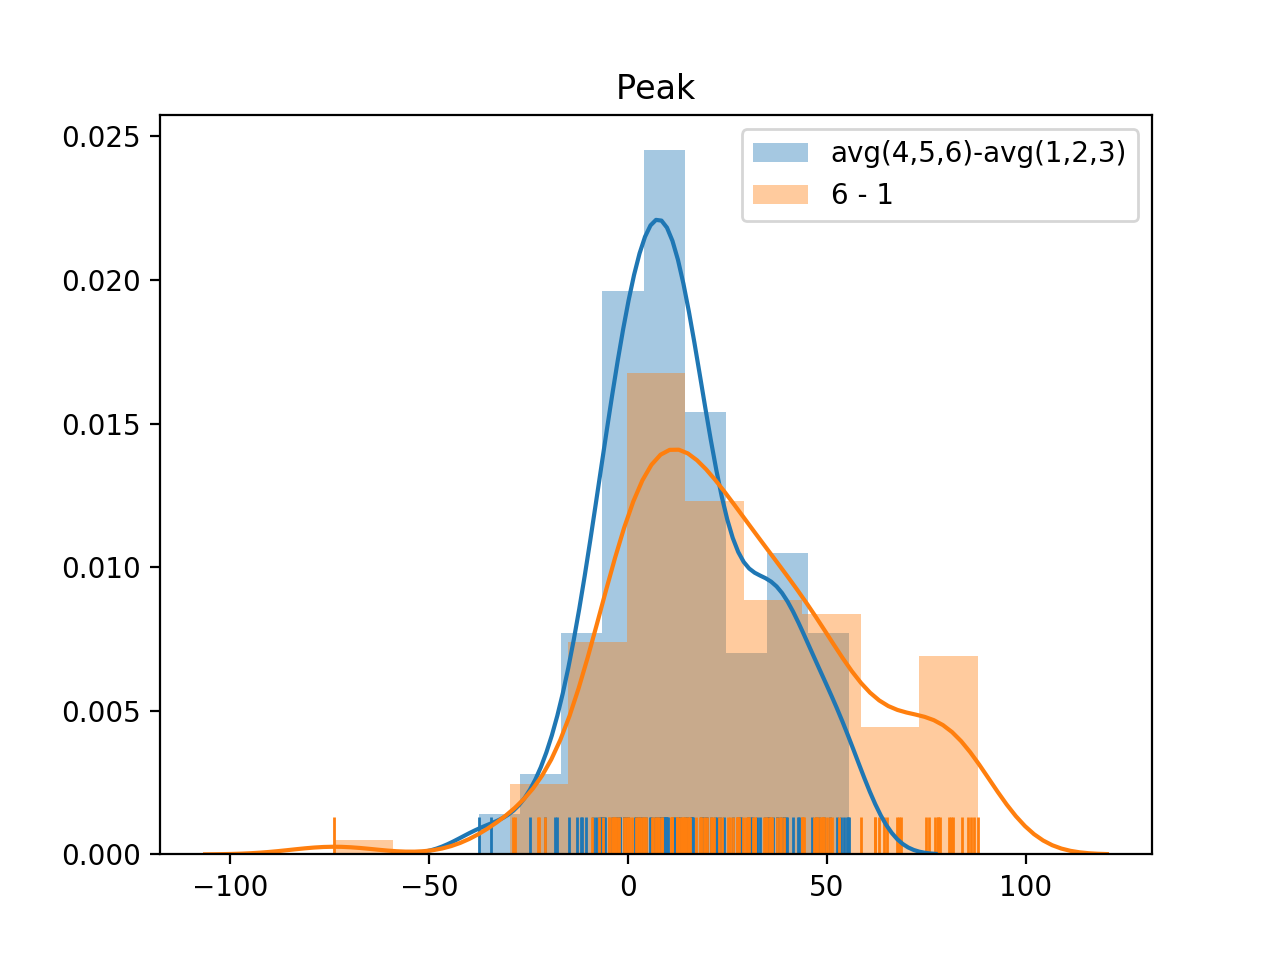

In [7]:
%matplotlib notebook
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

def learning_hist(series, title, dosample=False):
    if dosample:
        print(title, "score")
        print("Average difference between measures =", series['difference_between_measures'].mean(axis=0))
        print('skouras_learning measure has a variance of', np.var(series[['skouras_learning']].values))
        print('6-1 measure has a variance of', np.var(series[['six_minus_one']].values))
        print("Here is a random sample of 10 subjects.")
        print(series[['skouras_learning','six_minus_one', 'difference_between_measures']].sample(10))
    plt.figure()
    x = series[['skouras_learning']].values
    y = series[['six_minus_one']].values
    sns.distplot(x, kde=True, rug=True, label="avg(4,5,6)-avg(1,2,3)")
    sns.distplot(y, kde=True, rug=True, label="6 - 1")
    plt.legend()
    plt.title(title)
    plt.show()

aucdownserieslearning = add_learning_measures(aucdownseries)
skouradownserieslearning = add_learning_measures(skouradownseries)
ttpdownserieslearning = add_learning_measures(ttpdownseries)
peakdownserieslearning = add_learning_measures(peakdownseries)


learning_hist(aucdownserieslearning, "AUC", dosample=True)
learning_hist(skouradownserieslearning, "Skouras-Score", dosample=True)
learning_hist(ttpdownserieslearning, "Time-to-peak", dosample=True)
learning_hist(peakdownserieslearning, "Peak", dosample=True)

from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 250em; }</style>"))